**Pedro Rivero**  
Quantum Developer *@ IBM Quantum*  
pedro.rivero@ibm.com 

# Qiskit Estimator primitive

The Estimator primitive lets you calculate expectation values of quantum operators by specifying circuits and observables.  

<div class="alert alert-info">
    <i class="fas fa-info-circle"></i>
    <b>NOTICE</b><br/> 
    Official interface as of Qiskit Terra 0.22.0.
</div>

## Declaring inputs

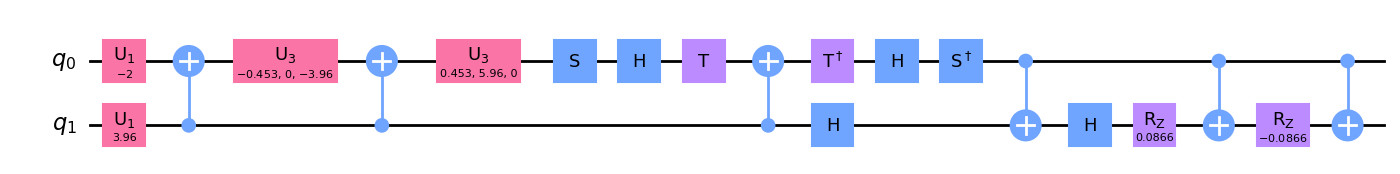

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
display(circuit.draw("mpl"))

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("ZZ")

## Running experiment

In [3]:
from qiskit.primitives import Estimator

estimator = Estimator()
job = estimator.run(circuit, observable)
simulation = job.result()

In [4]:
from zne.utils.serialization import EstimatorResultEncoder

print(EstimatorResultEncoder.dumps(simulation, indent=2))

{
  "values": [
    0.9999999999999984
  ],
  "metadata": [
    {}
  ]
}


# Zero Noise Extrapolation (ZNE)
![ZNE](../media/zne.png)

## Overall workflow

### (1) Building a ZNE Estimator

In [5]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi  # We need noise!
from zne import zne

ZNEEstimator = zne(BackendEstimator)  # Any implementation of BaseEstimator is valid
backend = FakeNairobi()
estimator = ZNEEstimator(backend=backend)

### (2) Configuring ZNE

In [6]:
from zne import ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

## NOISE FACTORS
noise_factors = range(1,9)

## NOISE AMPLIFIER
noise_amplifier = LocalFoldingAmplifier(
    gates_to_fold=2,
)

## EXTRPOLATOR
extrapolator = PolynomialExtrapolator(
    degree=2,
)

## ZNE STRATEGY
zne_strategy = ZNEStrategy(
    noise_factors=noise_factors,
    noise_amplifier=noise_amplifier,
    extrapolator=extrapolator,
)

### (3) Running a ZNE experiment

In [7]:
job = estimator.run(circuit, observable, zne_strategy=zne_strategy)
result = job.result()

print(EstimatorResultEncoder.dumps(result, indent=2))

{
  "values": [
    0.9524972098214297
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': 2, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4,
            5,
            6,
            7,
            8
          ],
          "values": [
            0.908203125,
            0.875,
            0.853515625,
            0.76171875,
            0.80078125,
            0.712890625,
            0.71484375,
            0.673828125
          ],
          "variance": [
            0.17516708374023438,
            0.234375,
            0.2715110778808594,
            0.4197845458984375,
            0.3587493896484375,
            0.4917869567871094,
            0.4889984130859375,
            0.5459556579589844
          ],
          "shots": [
            1024,
   

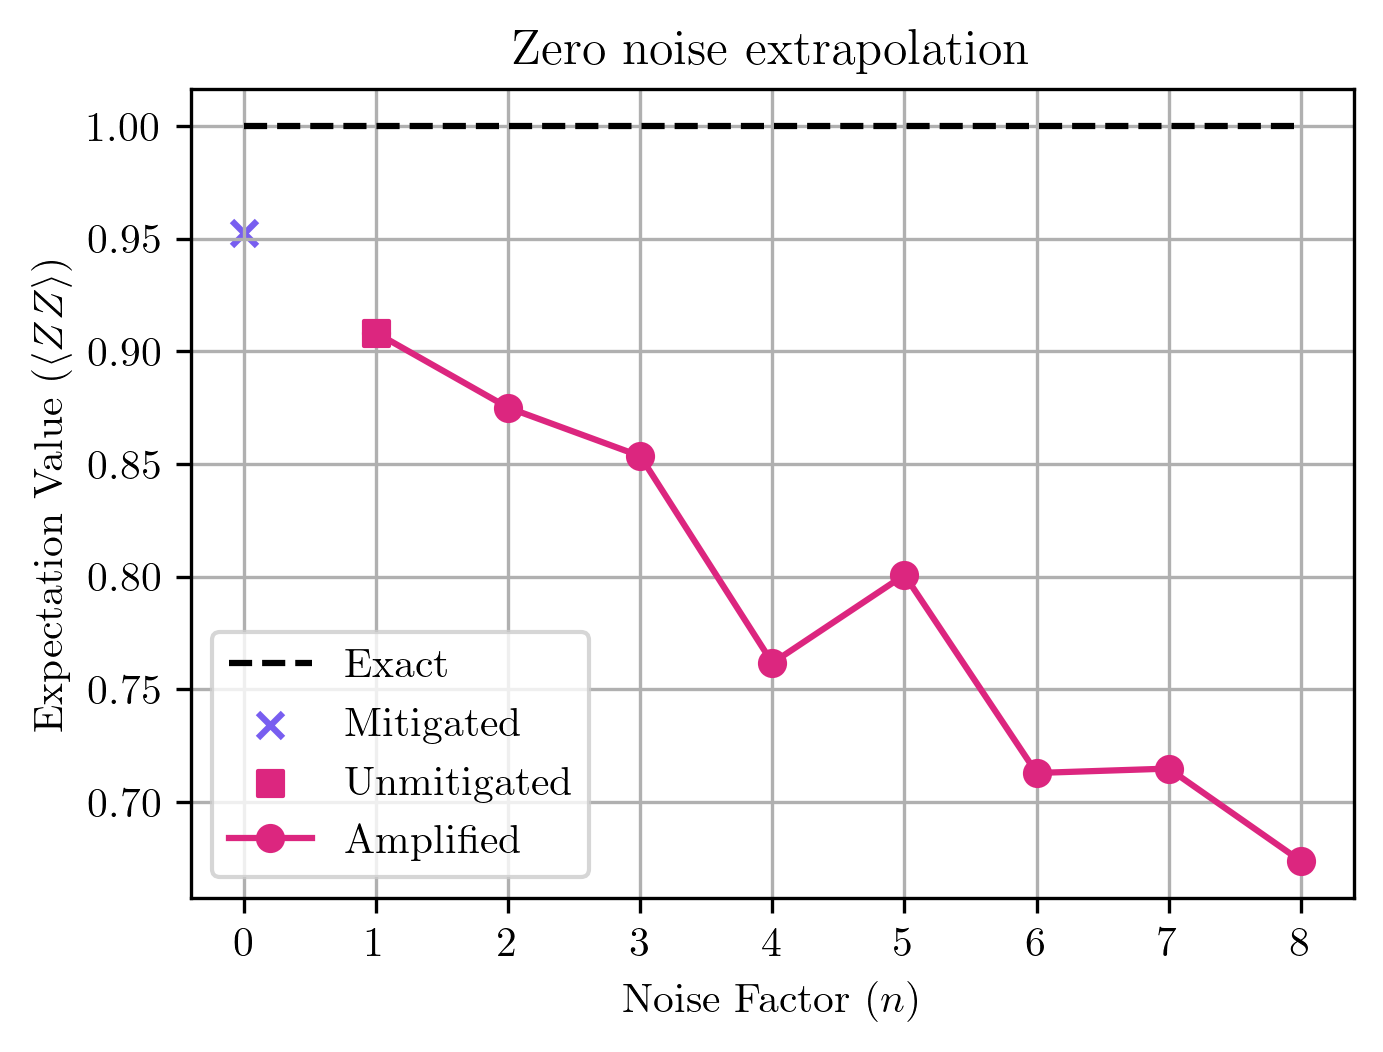

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

############################  DATA  ############################
exact = simulation.values[0]
mitigated = result.values[0]
noise_factors = result.metadata[0]["zne"]["noise_amplification"]["noise_factors"]
noisy_values = result.metadata[0]["zne"]["noise_amplification"]["values"]

############################  PLOT  ############################
plt.rcParams["figure.figsize"] = (5,3.5)
plt.grid(which='major',axis='both')

plt.plot([0, noise_factors[-1]], [exact, exact], "--", label=f"Exact", color="#000000")
plt.scatter(0, mitigated, label=f"Mitigated", marker="x", color="#785ef0")
if noise_factors[0] == 1:
    plt.scatter(
        noise_factors[0], noisy_values[0], 
        label=f"Unmitigated", marker="s", color="#dc267f",
    )
plt.plot(
    noise_factors, noisy_values, 
    label=f"Amplified", marker="o", color="#dc267f",
)

plt.title("Zero noise extrapolation")
plt.xlabel("Noise Factor ($n$)")
plt.ylabel(f"Expectation Value ($\langle ZZ \\rangle$)")
plt.legend()

plt.show()

## ZNE strategies

### Noise Amplification

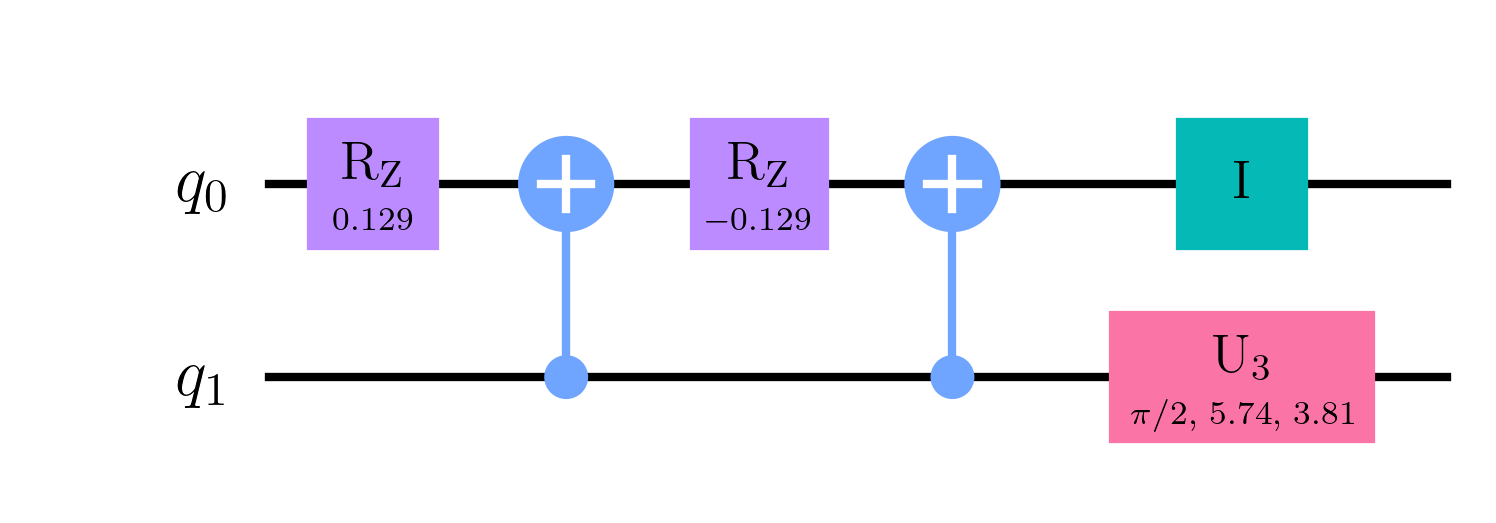

In [9]:
circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

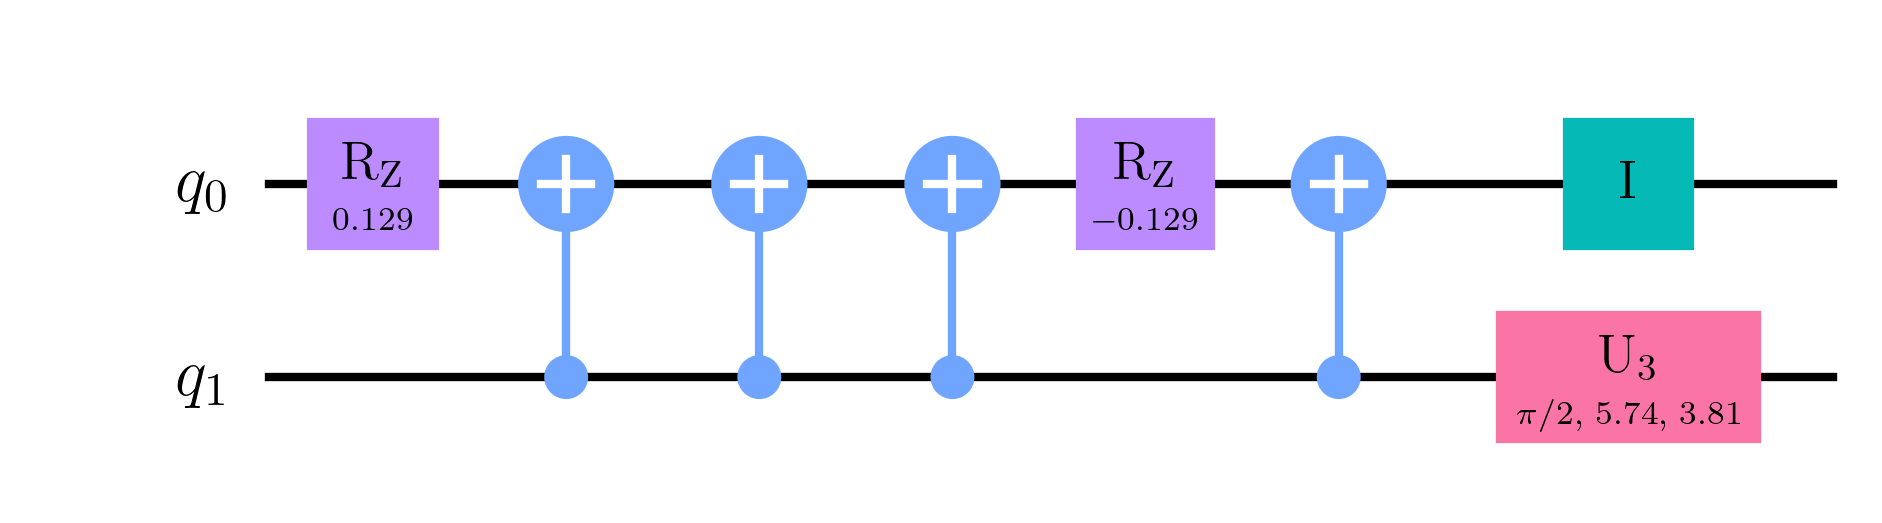

In [10]:
noise_amplifier = LocalFoldingAmplifier(
    gates_to_fold = 2,
    sub_folding_option = "from_first",
    random_seed = None,
)

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuit, noise_factor=2)
display(noisy_circuit.draw("mpl", plot_barriers=False))

### Extrapolation

![Extrapolation](../media/extrapolation.png)

### Custom ZNE strategies

The current implementation of `zne` allows us build custom noise amplification, and extrapolation techniques:

In [11]:
from zne.extrapolation import Extrapolator, ReckoningResult
from zne.noise_amplification import CircuitNoiseAmplifier


############################  NOISE AMPLIFIER  ############################
class CustomAmplifier(CircuitNoiseAmplifier):
    def amplify_circuit_noise(self, circuit, noise_factor):
        return circuit.copy()  # Dummy, nonperforming


############################  EXTRAPOLATOR  ############################
class CustomExtrapolator(Extrapolator):
    @property
    def min_points(self):
        return 2
    
    def _extrapolate_zero(self, x_data, y_data, sigma_x, sigma_y):
        value = 1.0
        std_error = 1.0
        metadata = {"meta": "data"}
        return ReckoningResult(value, std_error, metadata)  # Dummy, nonperforming

Which we then provide during instantiation through a `ZNEStrategy` object:

In [12]:
zne_strategy = ZNEStrategy(
    noise_amplifier=CustomAmplifier(),
    noise_factors=(1, 3),
    extrapolator=CustomExtrapolator(),
)
    
job = estimator.run(circuit, observable, zne_strategy=zne_strategy)    
result = job.result()

print(EstimatorResultEncoder.dumps(result, indent=2))

{
  "values": [
    1.0
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "CustomAmplifier",
          "noise_factors": [
            1,
            3
          ],
          "values": [
            0.0234375,
            0.013671875
          ],
          "variance": [
            0.99945068359375,
            0.9998130798339844
          ],
          "shots": [
            1024,
            1024
          ]
        },
        "extrapolation": {
          "extrapolator": "CustomExtrapolator",
          "variance": 0.0,
          "metadata": null
        }
      }
    }
  ]
}


## Conclusions and news

### Runtime integration with exclusive strategies
You can now access cutting edge ZNE strategies for enhanced error mitigation through _[Qiskit Runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/)_.

![source model](../media/runtime.png)

In [13]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright